# Finding Correlations

So you picked the forecasting project. Good for you! Forecasting is an important skill, and it's helpful to learn about the techchnologies out there that can make your life easier. Or worse, depending on how you look at it. ;)

### 1. Download the Kaggle forecasting data
We are assuming Kaggle.json is present in the directory you just logged in, this requires login to the EC2 instance and VI out the kaggle.json into the base directory, if you have not done this the next step will fail

In [21]:
!mkdir ~/.kaggle/
!pip install kaggle
!cp ~/kaggle.json /home/ec2-user/.kaggle/kaggle.json
!chmod 600 /home/ec2-user/.kaggle/kaggle.json
!ls /home/ec2-user/.kaggle/kaggle.json
!kaggle competitions download -c ams-2014-solar-energy-prediction-contest

mkdir: cannot create directory ‘/home/ec2-user/.kaggle/’: File exists
    100% |████████████████████████████████| 61kB 23.7MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 23.8MB/s ta 0:00:01
    100% |████████████████████████████████| 81kB 25.5MB/s ta 0:00:01
  Running setup.py bdist_wheel for kaggle ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/db/6a/80/6cd1892eb9b9b136333db3c74e16cba4e17e2c700f51541f06
  Running setup.py bdist_wheel for python-slugify ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/0f/96/ca/85f5b01165975402d1e37f8dd346df00dc39be1d0761bd17bb
Successfully built kaggle python-slugify
You are using pip version 10.0.1, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
/home/ec2-user/.kaggle/kaggle.json
train.csv: Skipping, found more recently modified local copy (use --force to force download)
100%|██████████████████████████████████████▊| 1.06G/1.07G [00:12<0

### 2. Finding Missing Data

In [39]:
import pandas as pd
import json
import sagemaker
import boto3
import numpy as np

In [27]:
df = pd.read_csv('train.csv')

In [141]:
# df.shape
df.isnull().values.any()
# dates = pd.date_range('19940101', periods=4)
# df1 = df.reindex(index=dates[0:4], columns=list(df.columns) + ['E'])
# df1.loc[dates[0]:dates[1], 'E'] = 1
#df1

False

In [25]:
df.head()

,Date,ACME,ADAX,ALTU,APAC,ARNE,BEAV,BESS,BIXB,BLAC,...,VINI,WASH,WATO,WAUR,WEAT,WEST,WILB,WIST,WOOD,WYNO
0,19940101,12384900,11930700,12116700,12301200,10706100,10116900,11487900,11182800,10848300,...,10771800,12116400,11308800,12361800,11331600,10644300,11715600,11241000,10490100,10545300
1,19940102,11908500,9778500,10862700,11666400,8062500,9262800,9235200,3963300,3318300,...,4314300,10733400,9154800,12041400,9168300,4082700,9228000,5829900,7412100,3345300
2,19940103,12470700,9771900,12627300,12782700,11618400,10789800,11895900,4512600,5266500,...,2976900,11775000,10700400,12687300,11324400,2746500,3686700,4488900,9712200,4442100
3,19940104,12725400,6466800,13065300,12817500,12134400,11816700,12186600,3212700,8270100,...,3476400,12159600,11907000,12953100,11903700,2741400,4905000,4089300,11401500,4365000
4,19940105,10894800,11545200,8060400,10379400,6918600,9936300,6411300,9566100,8009400,...,6393300,11419500,7334400,10178700,7471500,8235300,11159100,10651500,10006200,8568300


Each row here is a new point in time, and each column is an energy station. That means that each COLUMN is a unique time series data set. We are going to train our first model on a single column. Then, you can extend it by adding more columns.

In [27]:
target = df['ACME']

In [28]:
target.shape

(5113,)

Great! We have 5113 obervations. That's well over the 300-limit on DeepAR.

### 3. Histgramming
Lets build some histrograms because some of these may be pretty similar.

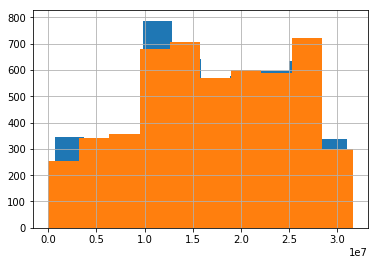

In [96]:
df.NINN.hist()
df.APAC.hist()

### Lets Map a bunch and see what happens.

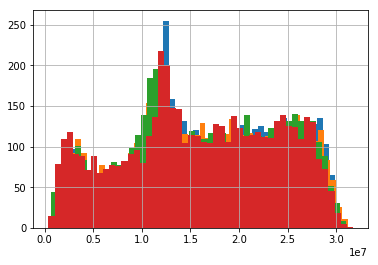

In [109]:
df.NINN.hist(bins=50)
df.PERK.hist(bins=50)
df.STIL.hist(bins=50)
df.STUA.hist(bins=50)

### 4. Finding Correlation
Lets see if some of these are correlated. Cheating: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

In [94]:
# Create correlation matrix
corr_matrix = df.corr(method='kendall')
#corr_matrix = df.corr(method='kendall')

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
to_drop

['NINN', 'PERK', 'STIL', 'STUA']

In [131]:
df1 = df
print("Starting with \n{}".format(len(df1.columns[1:])))
print("Dropping {}".format(to_drop) )
df2 = df1.drop(df1[to_drop], axis=1)
len(df2.columns[1:])

Starting with 
98
Dropping ['NINN', 'PERK', 'STIL', 'STUA']


94

### 5. TODO:  Lets write out the file 
This will help us load SageMaker. 

In [ ]:
# def write_dicts_to_file(path, data):
#     with open(path, 'wb') as fp:
#         for d in data:
#             fp.write(json.dumps(d).encode("utf-8"))
# #             fp.write("\n".encode('utf-8'))

In [32]:
write_dicts_to_file('train.json', train_set)
write_dicts_to_file('test.json', test_set)

In [33]:
!aws s3 cp train.json s3://forecasting-do-not-delete/train/train.json
!aws s3 cp test.json s3://forecasting-do-not-delete/test/test.json

upload: ./train.json to s3://forecasting-do-not-delete/train/train.json
upload: ./test.json to s3://forecasting-do-not-delete/test/test.json


### 4. Run a SageMaker Training Job
Ok! If everything worked, we should be able to train a model in SageMaker straight away.

In [34]:
sess = sagemaker.Session()
region = sess.boto_region_name
image = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")
role = sagemaker.get_execution_role()   

In [35]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sess,
    image_name=image,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='deepar-electricity-demo',
    output_path='s3://forecasting-do-not-delete/output'
)

In [36]:
hyperparameters = {
    
    # frequency interval is once per day
    "time_freq": 'D',
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    
    # let's use the last 30 days for context
    "context_length": str(30),
    
    # let's forecast for 30 days
    "prediction_length": str(30)
}

estimator.set_hyperparameters(**hyperparameters)

In [ ]:
data_channels = {
    "train": "s3://forecasting-do-not-delete/train/train.json",
    "test": "s3://forecasting-do-not-delete/test/test.json"
}

estimator.fit(inputs=data_channels, wait=True)

2019-08-01 16:17:22 Starting - Starting the training job...
2019-08-01 16:17:27 Starting - Launching requested ML instances......
2019-08-01 16:18:30 Starting - Preparing the instances for training......
2019-08-01 16:19:52 Downloading - Downloading input data
2019-08-01 16:19:52 Training - Downloading the training image...

### 5. Run Inference
If you made it this far, congratulations! None of this is easy. For your next steps, please open up the example notebook under the SageMakerExamples:
- SageMakerExamples/Introduction To Amazon Algorithms/DeepAR-Electricity.

That will walk you through both how to add more timeseries to your model, and how to get inference results out of it.

### 6. Extend Your Solution
Now you're getting forecasts, how will you extend your solution? How good are your forecasts? What about getting forecasts for the other stations? Is your model cognizant of the weather?

Spend your remaining time growing your modeling solution to leverage additional datasets. Then, think through how you'd set this up to run in production.